# TP: Machine Learning

## TP2: Classification

In machine learning, classification is related to supervised learning approaches in which the algorithm fits from an annotated set of data. This learning phase is followed by a validation phase to evaluate the classification model through several metrics. Once the model is correctly validated, a generalization phase is used to classify new data.

The given dataset was produced by the World Health Organization. It pooled the evolution of 20 features for 15 years and among numerous countries. One of the goals of this TP2 is to visualize feature space and try to predict the development of countries.

**Objectives:**
- Visualize the feature space
- Discuss the feasibility of feature space separation
- Normalize the datasets
- Train a K-NN, a decision tree, a random forest and a SVM
- Visualize the decision boundary for each method
- Create a test dataset
- Compute AUC scores on a evaluation dataset
- Tune hyperparameters
- Visualize the modification of decision boundary for each tuning
- Discuss the limits of the four implementations


## STEP 1: Feature space visualization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


You will work on the WHO dataset in the year 2000. This first step consists of choosing two features to perform a classification.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine learning/TP/Life_Expectancy_Data.csv")
df = df.dropna()
df.info()

df1 = df[(df.Year == 2000)]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1649 entries, 0 to 2937
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          1649 non-null   object 
 1   Longitude                        1649 non-null   float64
 2   Latitude                         1649 non-null   float64
 3   Continent                        1649 non-null   object 
 4   Year                             1649 non-null   int64  
 5   Status                           1649 non-null   object 
 6   Life_expectancy                  1649 non-null   float64
 7   Adult_mortality                  1649 non-null   float64
 8   Infant_deaths                    1649 non-null   int64  
 9   Alcohol                          1649 non-null   float64
 10  Percentage_expenditure           1649 non-null   float64
 11  Hepatitis_B                      1649 non-null   float64
 12  Measles             

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

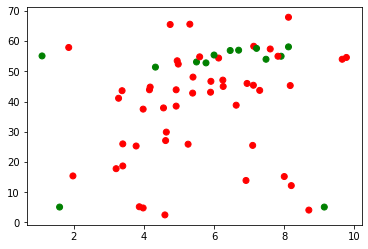

In [ ]:
df_X = df1[['Total_expenditure', 'BMI']]
df_Status = df1[['Status']]

df_Y = df_Status.replace(['Developing', 'Developed'], [0, 1])

np1 = df_X.to_numpy()
plt.scatter(np1[:,0], np1[:,1], c=np.squeeze(df_Y.to_numpy()), cmap=matplotlib.colors.ListedColormap(['red', 'green']))
plt



the label status is binarized because the type of array is an object(string) and we have 2 string (Developing, Developed) so to be able to use the fonction scatter we need convert the type string to integer (so 0 for developing and 1 for developed).

Is this feature space easily separable? Justify your response

No because each blue point is very close to red point.



Plot Total expenditure against Schooling

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

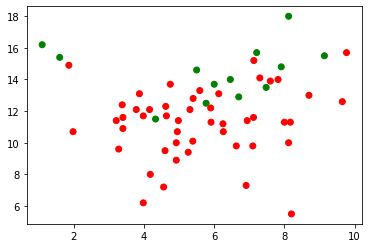

In [ ]:
df_X = df1[['Total_expenditure', 'Schooling']]
df_Status = df1[['Status']]

df_Y = df_Status.replace(['Developing', 'Developed'], [0, 1])

np1 = df_X.to_numpy()
plt.scatter(np1[:,0], np1[:,1], c=np.squeeze(df_Y.to_numpy()), cmap=matplotlib.colors.ListedColormap(['red', 'green']))
plt



Plot Life Expectancy against Schooling

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

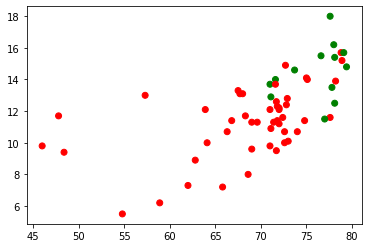

In [ ]:
df_X = df1[['Life_expectancy', 'Schooling']]
df_Status = df1[['Status']]

df_Y = df_Status.replace(['Developing', 'Developed'], [0, 1])

np1 = df_X.to_numpy()
plt.scatter(np1[:,0], np1[:,1], c=np.squeeze(df_Y.to_numpy()), cmap=matplotlib.colors.ListedColormap(['red', 'green']))
plt


Life Expenctancy and schooling is the best feature to use because the green point is gather in the same area so it's more simple to classify them.

## STEP 2: Dataset normalization

To classify, the values in the learning dataset must be normalized (aka between 0 and 1). This normalization can be performed through various ways.


Normalize df_X. This normalization should perfectly frame the data (aka the minimum and the maximum values of each feature should be respectively 0 and 1).

In [ ]:
df_X_norm = pd.DataFrame(index = df_X.index, columns = df_X.columns, dtype = float)

df_X_norm.iloc[:,:1] = (df_X.iloc[:,:1]-df_X.iloc[:,:1].min())/(df_X.iloc[:,:1].max()-df_X.iloc[:,:1].min())
df_X_norm.iloc[:,1:] = (df_X.iloc[:,1:]-df_X.iloc[:,1:].min())/(df_X.iloc[:,1:].max()-df_X.iloc[:,1:].min())
print(df_X_norm)

      Life_expectancy  Schooling
15           0.263473      0.000
31           0.796407      0.416
111          0.778443      0.456
143          0.961078      0.792
239          0.658683      0.608
...               ...        ...
2696         0.838323      0.416
2745         0.643713      0.624
2825         0.871257      0.680
2857         0.688623      0.328
2937         0.000000      0.344

[61 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.9294871794871794


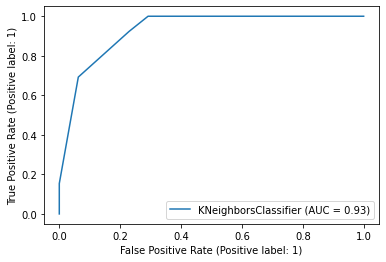

In [ ]:
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier

np_X_norm = df_X_norm.to_numpy()
np_Y = df_Y.to_numpy()

clf1 = KNeighborsClassifier(n_neighbors=5)
clf1.fit(np_X_norm, np_Y)

np_Y_pred = clf1.predict_proba(df_X_norm)

print(roc_auc_score(np_Y, np_Y_pred[:,1]))
plot_roc_curve(clf1, np_X_norm, np_Y)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.9198717948717949


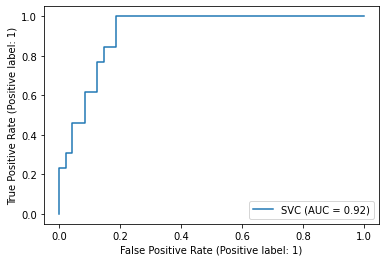

In [ ]:
from sklearn.svm import SVC

clf2 = SVC(C=2.0, kernel='linear', probability = True)
clf2.fit(np_X_norm, np_Y)

np_Y_pred = clf2.predict_proba(df_X_norm)

print(roc_auc_score(np_Y, np_Y_pred[:,1]))
plot_roc_curve(clf2, np_X_norm, np_Y)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.9799679487179488


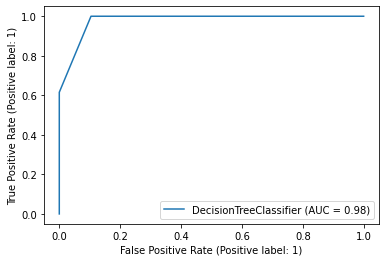

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf3 = DecisionTreeClassifier(max_depth=3)
clf3.fit(np_X_norm, np_Y)

np_Y_pred = clf3.predict_proba(df_X_norm)

print(roc_auc_score(np_Y, np_Y_pred[:,1]))
plot_roc_curve(clf3, np_X_norm, np_Y)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.9871794871794871


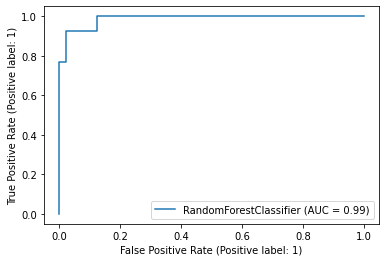

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf4 = RandomForestClassifier(n_estimators=100, max_depth=3)
clf4.fit(np_X_norm, np_Y)

np_Y_pred = clf4.predict_proba(df_X_norm)

print(roc_auc_score(np_Y, np_Y_pred[:,1]))
plot_roc_curve(clf4, np_X_norm, np_Y)
plt.show()


KNN :
  - n (number of neighbor)

Linear SVM :
  - c (support vector classification)
  - kernel

Decision Tree :
  - max_deth (size of tree)

Random forest :
  - number_estimator (number of tree)


The ROC curve is the true positive rate against the false positive rate. We can see that the knn is the worst model if we want maximize the specifisity and also if we want to maximize the sensivity. SVC have a bad specificity and sensitivity. the best model is Decision tree and random forest according to its ROC curve


The Area Under the ROC Curve is the AUC so AUC is the integral of the ROC curve

According to the ROC curve, which model is the best if we want to maximize the sensitivity ?

DecisionTreeClassifier is the best if we want to maximize the sensitivity because it have the lowest false positive rate with a True positive Rate equals to 1.


RandomForestClassifier is the best if we want to maximize the specificite because it have the highest True positive Rate with false positive rate equals to 0.


RandomForestClassifier is the best model according to AUC value (0.99). More the AUC value is closer to 1 more the model is better.

For a two-classes problem, a decision boundary is a hypersurface which splits the feature space between two sets (for each class). Then this surface is composed of all the equiprobability points in the feature space.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

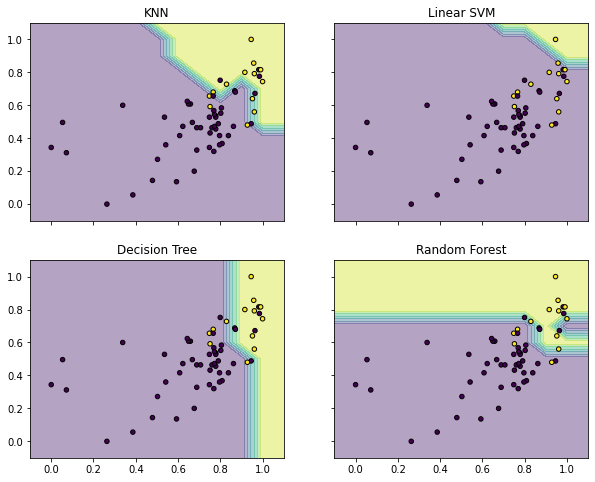

In [ ]:
from itertools import product

x_min, x_max = np_X_norm[:, 0].min() - 0.1, np_X_norm[:, 0].max() + 0.1
y_min, y_max = np_X_norm[:, 1].min() - 0.1, np_X_norm[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, clf4],
                        ['KNN', 'Linear SVM', 'Decision Tree', 'Random Forest']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(np_X_norm[:, 0], np_X_norm[:, 1], c=np_Y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt


The main probleme of the classification step with this dataset is that the datat is too close to each other.

KNN suite better for this classification task because the boundery separate the yellow and black point with the lowest error.


## STEP 3: Biases correction and model tuning

In this part, you will focus on improving the AUC scores of the four methods.

Firstable, you will weigh the classes to balance the classifier response. Then you will tune various hyperparameters.



Compute the percentage of "Developed" class against the size the np_Y.

In [ ]:
number_Developed = 0
for i in range(len(np_Y)):
    if np_Y[i] == 1 :
        number_Developed = number_Developed + 1

Developed_rate =  number_Developed/len(np_Y)
print(Developed_rate)

0.21311475409836064


SVM, Decision Tree and Random Forest algorithms have a parameter named:

```
class_weight
```
Here is a extract from sklearn documentation:

**class_weight** dict, list of dict or “balanced”, default=None

Weights associated with classes in the form {class_label: weight}. If None, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.

The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data.




Balance SVM, Decision Tree and Random Forest classifiers and plot the decision boundaries

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

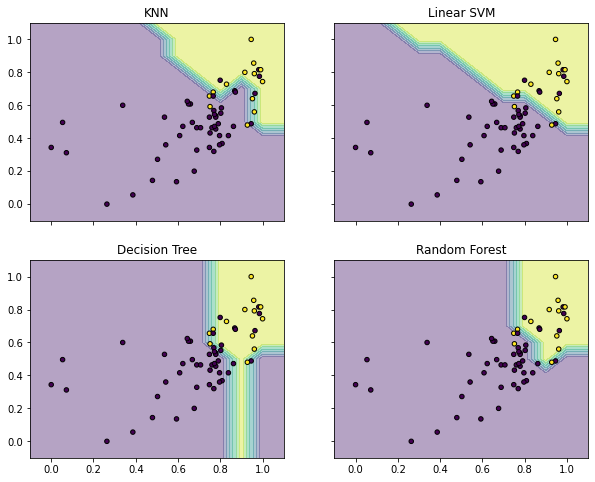

In [ ]:
clf3 = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
clf3.fit(np_X_norm, np_Y)

clf4 = RandomForestClassifier(n_estimators=100, max_depth=3, class_weight='balanced')
clf4.fit(np_X_norm, np_Y)

clf2 = SVC(C=2.0, kernel='linear', probability = True, class_weight='balanced')
clf2.fit(np_X_norm, np_Y)

x_min, x_max = np_X_norm[:, 0].min() - 0.1, np_X_norm[:, 0].max() + 0.1
y_min, y_max = np_X_norm[:, 1].min() - 0.1, np_X_norm[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, clf4],
                        ['KNN','Linear SVM', 'Decision Tree', 'Random Forest']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(np_X_norm[:, 0], np_X_norm[:, 1], c=np_Y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt

**TO CODE 3.3**

Compute the new AUC scores

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.9871794871794871


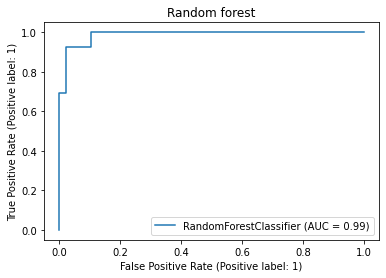

0.9423076923076923


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


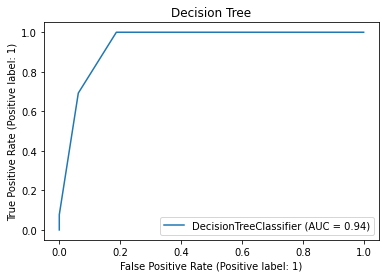

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


0.9182692307692308


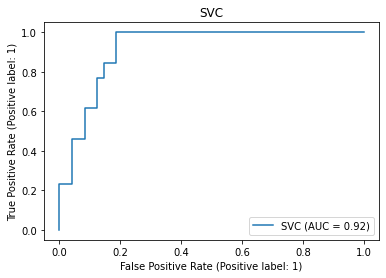

In [ ]:
np_Y_pred = clf4.predict_proba(df_X_norm)

print(roc_auc_score(np_Y, np_Y_pred[:,1]))
plot_roc_curve(clf4, np_X_norm, np_Y)
plt.title('Random forest')
plt.show()

np_Y_pred = clf3.predict_proba(df_X_norm)

print(roc_auc_score(np_Y, np_Y_pred[:,1]))
plot_roc_curve(clf3, np_X_norm, np_Y)
plt.title('Decision Tree')
plt.show()

np_Y_pred = clf2.predict_proba(df_X_norm)

print(roc_auc_score(np_Y, np_Y_pred[:,1]))
plot_roc_curve(clf2, np_X_norm, np_Y)
plt.title('SVC')
plt.show()



The AUC don't increase because AUC rate is in range 0 to 1 while balance adjust weigth using y class [0 1]


Let's focus on the SVM classifier.

Sklearn allows multiple kernels.

Here is an extract of the documentation:

**kernel** {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’

Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape (n_samples, n_samples).




Test the gaussian and the polynomial kernels with balanced classes and plot the decision boundaries

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

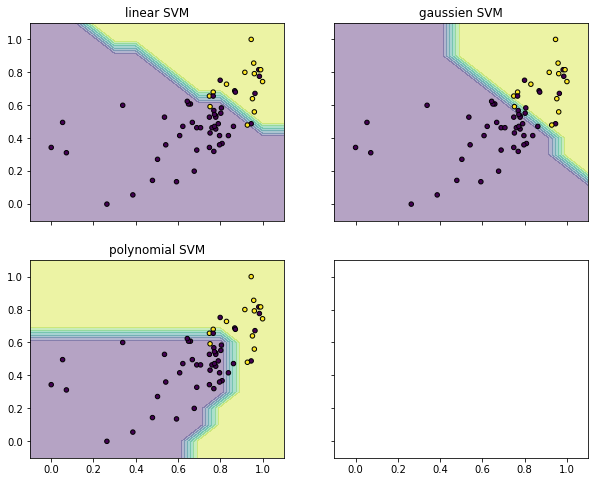

In [ ]:
clf2_gaussien = SVC(C=2.0, kernel='rbf', probability = True, class_weight='balanced')
clf2_gaussien.fit(np_X_norm, np_Y)

clf2_polynomial = SVC(C=2.0, kernel='poly', probability = True, class_weight='balanced')
clf2_polynomial.fit(np_X_norm, np_Y)

x_min, x_max = np_X_norm[:, 0].min() - 0.1, np_X_norm[:, 0].max() + 0.1
y_min, y_max = np_X_norm[:, 1].min() - 0.1, np_X_norm[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf2,clf2_gaussien, clf2_polynomial],
                        ['linear SVM','gaussien SVM','polynomial SVM']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(np_X_norm[:, 0], np_X_norm[:, 1], c=np_Y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt



polynomial SVM is better for this data because for gaussien SVM and linear SVM more black point are in yellow class aera so more error.


Tune the parameters for Decision Tree and Random Forest algorithms and plot the decision boundaries

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

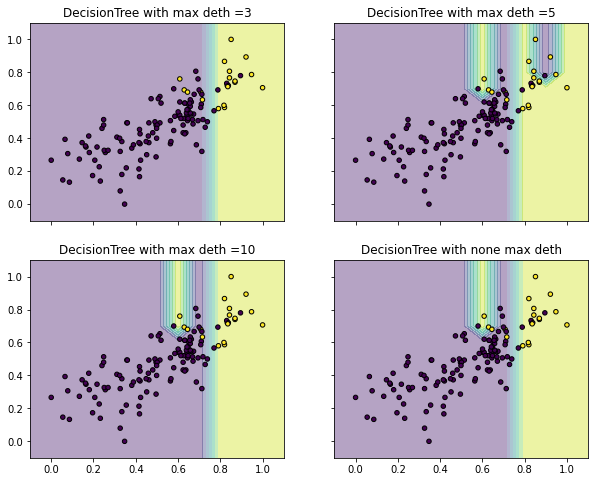

In [ ]:
clf3 = DecisionTreeClassifier(max_depth=3)
clf3.fit(np_X_norm, np_Y)

clf3_5 = DecisionTreeClassifier(max_depth=5)
clf3_5.fit(np_X_norm, np_Y)

clf3_10 = DecisionTreeClassifier(max_depth=10)
clf3_10.fit(np_X_norm, np_Y)

clf3_None = DecisionTreeClassifier()
clf3_None.fit(np_X_norm, np_Y)

x_min, x_max = np_X_norm[:, 0].min() - 0.1, np_X_norm[:, 0].max() + 0.1
y_min, y_max = np_X_norm[:, 1].min() - 0.1, np_X_norm[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf3,clf3_5, clf3_10, clf3_None],
                        ['DecisionTree with max deth =3','DecisionTree with max deth =5','DecisionTree with max deth =10', 'DecisionTree with none max deth']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(np_X_norm[:, 0], np_X_norm[:, 1], c=np_Y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt

## STEP 4: An evaluation dataset

This part is to test the generalization of your models.

You trained several classifiers on two features extracted from the year 2000.



Apply your models on the year 2012

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tru

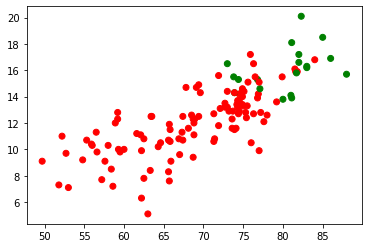

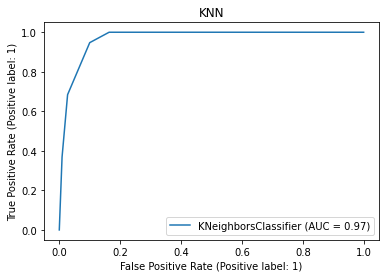

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


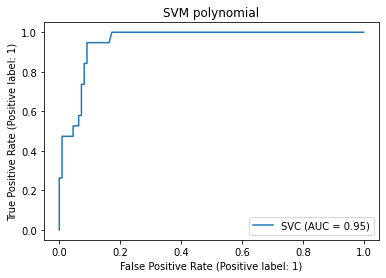

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


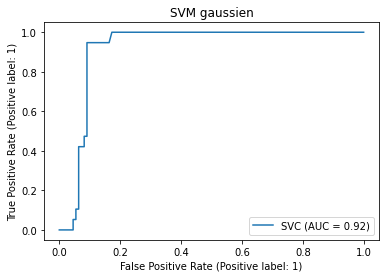

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


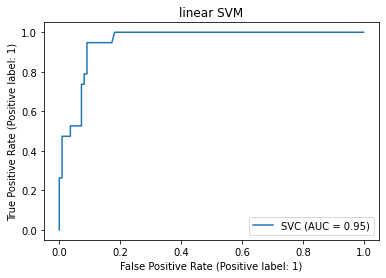

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


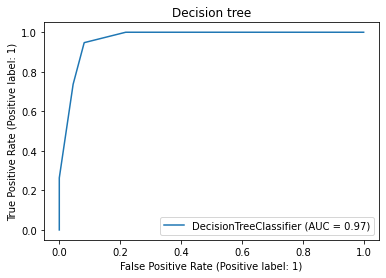

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


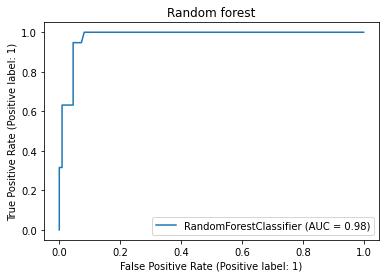

AUC score :
Random forest : 0.9787081339712919
Decision tree : 0.9679425837320574
linear SVM : 0.9528708133971291
Gaussien SVM : 0.9184210526315789
Poly SVM : 0.9538277511961722
KNN : 0.9688995215311005


In [ ]:
# feature (Life_expectancy, Schooling) for the year 2000

df2 = df[(df.Year == 2012)]
df_X = df2[['Life_expectancy', 'Schooling']]
df_Status = df2[['Status']]

df_Y = df_Status.replace(['Developing', 'Developed'], [0, 1])

np1 = df_X.to_numpy()
plt.scatter(np1[:,0], np1[:,1], c=np.squeeze(df_Y.to_numpy()), cmap=matplotlib.colors.ListedColormap(['red', 'green']))
plt

# data Normalize [0 1]

df_X_norm = pd.DataFrame(index = df_X.index, columns = df_X.columns, dtype = float)

df_X_norm.iloc[:,:1] = (df_X.iloc[:,:1]-df_X.iloc[:,:1].min())/(df_X.iloc[:,:1].max()-df_X.iloc[:,:1].min())
df_X_norm.iloc[:,1:] = (df_X.iloc[:,1:]-df_X.iloc[:,1:].min())/(df_X.iloc[:,1:].max()-df_X.iloc[:,1:].min())

np_X_norm = df_X_norm.to_numpy()
np_Y = df_Y.to_numpy()

# modele

clf3_2012 = DecisionTreeClassifier(max_depth=3, class_weight='balanced')
clf3_2012.fit(np_X_norm, np_Y)

clf4_2012 = RandomForestClassifier(n_estimators=100, max_depth=3, class_weight='balanced')
clf4_2012.fit(np_X_norm, np_Y)

clf2_2012 = SVC(C=2.0, kernel='linear', probability = True, class_weight='balanced')
clf2_2012.fit(np_X_norm, np_Y)

clf2_2012_gaussien = SVC(C=2.0, kernel='rbf', probability = True, class_weight='balanced')
clf2_2012_gaussien.fit(np_X_norm, np_Y)

clf2_2012_poly = SVC(C=2.0, kernel='poly', probability = True, class_weight='balanced')
clf2_2012_poly.fit(np_X_norm, np_Y)

clf1_2012 = KNeighborsClassifier(n_neighbors=5)
clf1_2012.fit(np_X_norm, np_Y)

np_Y_pred = clf1_2012.predict_proba(df_X_norm)
score_clf1_2012 = roc_auc_score(np_Y, np_Y_pred[:,1])

plot_roc_curve(clf1_2012, np_X_norm, np_Y)
plt.title('KNN')
plt.show()

np_Y_pred = clf2_2012_poly.predict_proba(df_X_norm)
score_clf2_2012_poly = roc_auc_score(np_Y, np_Y_pred[:,1])

plot_roc_curve(clf2_2012_poly, np_X_norm, np_Y)
plt.title('SVM polynomial')
plt.show()

np_Y_pred = clf2_2012_gaussien.predict_proba(df_X_norm)

score_clf2_2012_gaussien = roc_auc_score(np_Y, np_Y_pred[:,1])

plot_roc_curve(clf2_2012_gaussien, np_X_norm, np_Y)
plt.title('SVM gaussien')
plt.show()

np_Y_pred = clf2_2012.predict_proba(df_X_norm)

score_clf2_2012 = roc_auc_score(np_Y, np_Y_pred[:,1])

plot_roc_curve(clf2_2012, np_X_norm, np_Y)
plt.title('linear SVM')
plt.show()

np_Y_pred = clf3_2012.predict_proba(df_X_norm)

score_clf3_2012 = roc_auc_score(np_Y, np_Y_pred[:,1])

plot_roc_curve(clf3_2012, np_X_norm, np_Y)
plt.title('Decision tree')
plt.show()

np_Y_pred = clf4_2012.predict_proba(df_X_norm)

score_clf4_2012 = roc_auc_score(np_Y, np_Y_pred[:,1])

plot_roc_curve(clf4_2012, np_X_norm, np_Y)
plt.title('Random forest')
plt.show()

print(
    'AUC score :\nRandom forest : {}\nDecision tree : {}\nlinear SVM : {}\nGaussien SVM : {}\nPoly SVM : {}\nKNN : {}'.format(
        score_clf4_2012, score_clf3_2012, score_clf2_2012, score_clf2_2012_gaussien, score_clf2_2012_poly, score_clf1_2012
        )
    )

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

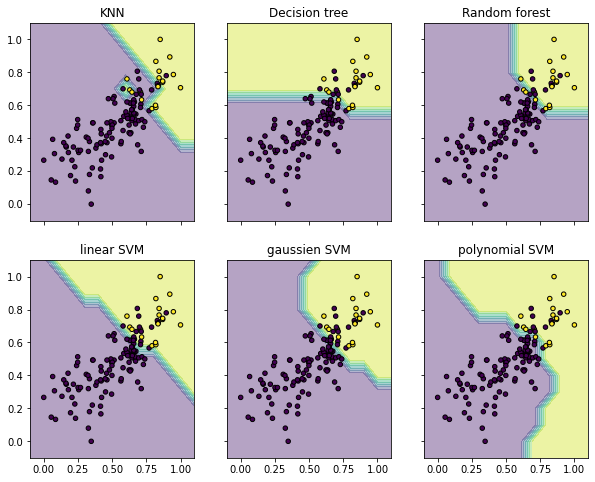

In [ ]:
x_min, x_max = np_X_norm[:, 0].min() - 0.1, np_X_norm[:, 0].max() + 0.1
y_min, y_max = np_X_norm[:, 1].min() - 0.1, np_X_norm[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1_2012,clf3_2012,clf4_2012,clf2_2012,clf2_2012_gaussien, clf2_2012_poly],
                        ['KNN','Decision tree','Random forest','linear SVM','gaussien SVM','polynomial SVM']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(np_X_norm[:, 0], np_X_norm[:, 1], c=np_Y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt


We can see that our model is still relevant in the year 2012 the AUC ROC metrics is approximatively the same and the line boundary is still good .

we see like the last data (year 2000) the best model is random forest if we want maximize specifities but if we want maximize sensivitive random forest is still better.

Additionnaly AUC is better for random forest(0.98) but lower than the last data (year 2000).
